### Description:

In this task you will work with software AES-128 running on ESP32. 

This AES-128 is implemented with T-tables; however, designers put a random delay before each "atom" operation, such as one MixColumn computation (see code_sample.txt in support folder).


You have access to plaintexts, ciphertexts and associated traces.
Oscilloscope snapshot shows an entire AES execution. 

The measurements were performed with LeCroy WaveRunner Zi625 and a differential probe

### Tips:

A 'trace' is a side-channel information measured between the VCC and the GND pins of the WROOM module (ESP32). 

Usually, CPU is vulnerable either to Hamming weight or to Hamming distance data models. There might be more than one instruction leaking secret data.

In this example a trace is a 15000 bytes long array of int8 (the amplitude of the measured voltage).

This array contains various encryption information measured with noise.

### Task:

Your main task is to get the master key.

The master key is in the form of SCA{XXXXXXXXXXX}, where X is a ASCII printable symbol.

### AES-128 encryption measured at high sampling rate

Green signal - a GPIO trigger used to synchronize all the traces

Red signal   - VCC voltage variation during AES-128 encryption

<img src="support/osc_snap.png">

# Some documentation
- [Askip une attaque](https://www.researchgate.net/publication/261251068_Cache-Access_Pattern_Attack_on_Disaligned_AES_T-Tables)
- [Explication T-Table](https://www.goggleheadedhacker.com/blog/post/reversing-crypto-functions-aes#aes-lookup-table-t-table-method)

In [1]:
import binascii
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sca_training
from tqdm.notebook import trange, tqdm
import struct
import defs

%matplotlib inline

In [2]:
def gmul(a, b):
    p = 0

    for c in range(8):
        if b & 1:
            p ^= a
        a <<= 1
        if a & 0x100:
            a ^= 0x11b
        b >>= 1

    return p

def generate_t_tables():
    t1 = []
    t2 = []
    t3 = []
    t4 = []
    t5 = []
    SBOX = sca_training.Sbox
    for i in range(len(SBOX)):
        word1 = [gmul(SBOX[i], 2), SBOX[i],
                 SBOX[i], gmul(SBOX[i], 3)]
        word2 = [gmul(SBOX[i], 3), gmul(SBOX[i], 2),
                 SBOX[i], SBOX[i]]
        word3 = [SBOX[i], gmul(SBOX[i], 3),
                 gmul(SBOX[i], 2), SBOX[i]]
        word4 = [SBOX[i], SBOX[i],
                 gmul(SBOX[i], 3), gmul(SBOX[i], 2)]
        word5 = [SBOX[i]] * 4
        t1.append(struct.unpack('>I', bytes(word1))[0])
        t2.append(struct.unpack('>I', bytes(word2))[0])
        t3.append(struct.unpack('>I', bytes(word3))[0])
        t4.append(struct.unpack('>I', bytes(word4))[0])
        t5.append(struct.unpack('>I', bytes(word5))[0])

    return t1,t2,t3,t4,t5

ft1 = lambda x : sca_training.HW_uint8[sca_training.Sbox[x]]
ft2 = lambda x : sca_training.HW_uint8[[gmul(xs, 2) for xs in sca_training.Sbox[x]]]
ft3 = lambda x : sca_training.HW_uint8[[gmul(xs, 3) for xs in sca_training.Sbox[x]]]

t1, _, _, _, _ = generate_t_tables()

In [3]:
numfiles    = 120
numtraces_per_file = 1000

numtraces  = 120000
numsamples = 15000

def ReadData():
    global numtraces
    global numsamples
    global numfiles
    global numtraces_per_file

    traces = np.zeros((numtraces, numsamples), dtype = np.int8)
    ptexts = np.zeros((numtraces, 16), dtype = np.uint8)
    #ctexts = np.zeros((numtraces, 16), dtype = np.uint8)

    for i_file in trange(numfiles):
        h5file = r'../data/aes_{}'.format(i_file * numtraces_per_file) + r'.hdf5'

        with h5py.File(h5file, 'r') as hdf5_file:
            ptexts[(i_file*numtraces_per_file):((i_file + 1)*numtraces_per_file),:] = hdf5_file['ptexts'][:,:].astype('uint8')
            #ctexts[(i_file*numtraces_per_file):((i_file + 1)*numtraces_per_file),:] = hdf5_file['ctexts'][:,:].astype('uint8')
            traces[(i_file*numtraces_per_file):((i_file + 1)*numtraces_per_file),:] = hdf5_file['traces'][:,:].astype('int8')


    print('Ptexts size:', ptexts.shape)
    #print('Ctexts size:', ctexts.shape)
    print('Traces size:', traces.shape)
    print('Completed')

    return ptexts, traces

In [4]:
ptexts, traces = ReadData()

  0%|          | 0/120 [00:00<?, ?it/s]

Ptexts size: (120000, 16)
Traces size: (120000, 15000)
Completed


In [5]:
mask = np.load('../data/mask.npy')
clean_ptexts = ptexts[mask]
clean_traces = traces[mask]

In [6]:
centered_traces = np.subtract(clean_traces.T, np.mean(clean_traces, axis=1)).T

In [ ]:
# OPT
plt.title("Average trace")
mn = np.mean(centered_traces,axis=0)
print("Mean computed")
plt.plot(mn)

In [ ]:
# OPT
trace_start = 1
trace_count = 1
start = 200
end = start+2000
plt.figure(figsize=(18, 10))
plt.plot(np.mean(centered_traces[trace_start:trace_start+trace_count,start:end], axis=0))

In [7]:
def matrix_corrcoef(matrix, vector, prog=False):
    if prog:
        return np.array([abs(np.corrcoef(vector, row)[0][1]) for row in tqdm(matrix)])
    else:
        return np.array([abs(np.corrcoef(vector, row)[0][1]) for row in matrix])

In [18]:
frame_start = 1000
frame_end = 3000
trace_start = 0
trace_end = 119_309

p = clean_ptexts[trace_start:trace_end].T
t = centered_traces[trace_start:trace_end].T[frame_start:frame_end]

print(p.shape)
print(t.shape)
assert p.shape[1] == t.shape[1], "Shape not matching !"

(16, 119309)
(2000, 119309)


In [19]:
print(t.shape)

# Compute averaged samples
# (True, 200)
moving_avg = False
window = 125
assert t.shape[0] % window == 0, f"Window must be a multiple of {t.shape[0]}"

if moving_avg:
    t_avg = [np.mean(t[i:(i+window)], axis=0) for i in trange(t.shape[0] - window)]
else:
    t_avg = [np.mean(t[i*window:((i+1)*window)], axis=0) for i in trange(t.shape[0] // window)]
print("Avg computed, convert to np.array")
t_avg = np.array(t_avg)

# Check result
print(t_avg.shape)
if moving_avg:
    assert t_avg.shape[0] == t.shape[0] - window
else:
    assert t_avg.shape[0] == t.shape[0] // window
assert t_avg.shape[1] == t.shape[1]

(2000, 119309)


  0%|          | 0/16 [00:00<?, ?it/s]

Avg computed, convert to np.array
(16, 119309)


Mean computed


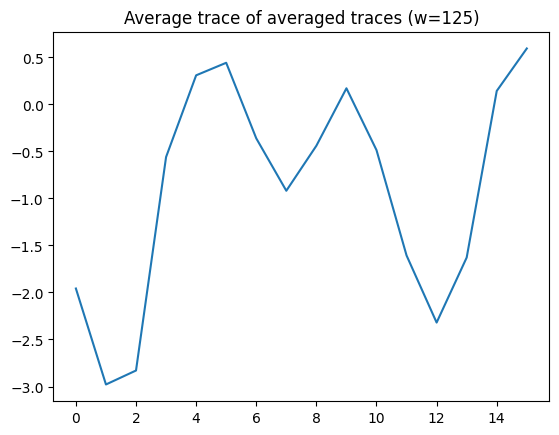

In [20]:
# OPT
plt.title(f"Average trace of averaged traces (w={window})")
mn = np.mean(t_avg,axis=1)
print("Mean computed")
plt.plot(mn)

In [100]:
# OPT
keys = [
    ('S', 0, ft1),
    ('C', 1, ft1),
    ('A', 2, ft1),
    ('{', 3, ft1),
]

corrs_k = []
for k, i, f in tqdm(keys):
    k = ord(k)
    cand = f(np.bitwise_xor(p[i], k))
    all_corr = matrix_corrcoef(t_avg, cand)
    corrs_k.append(all_corr)

  0%|          | 0/4 [00:00<?, ?it/s]

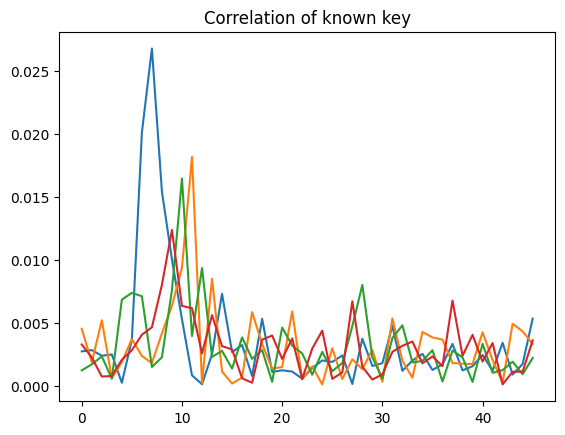

In [101]:
# OPT
[plt.plot(corr) for corr in corrs_k]
#plt.plot(corrs_k[3])
_ = plt.title("Correlation of known key")

In [21]:
# ATTACK
k10_max = [0]*16
corrs_max = [[] for _ in range(16)]
idx = range(16) #range(4,15)
candidates = range(32,127)

for i in tqdm(idx):
    pcc = 0
    for k in tqdm(candidates):
        cand = sca_training.HW_uint8[sca_training.Sbox[np.bitwise_xor(p[i], k)]] # First round
        all_corr = matrix_corrcoef(t_avg, cand)
        corr = max(all_corr)
        if corr > pcc:
            pcc = corr
            k10_max[i] = k
            corrs_max[i].append(all_corr)
            print(round(pcc,4))
    print(chr(k10_max[i]))

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

0.0054
0.0063
0.0064
0.0069
0.007
0.0077
0.0079
0.0096
0.028
S


  0%|          | 0/95 [00:00<?, ?it/s]

0.0057
0.0066
0.0076
0.0094
0.0171
C


  0%|          | 0/95 [00:00<?, ?it/s]

0.006
0.0065
0.008
0.0091
0.0097
0.0142
A


  0%|          | 0/95 [00:00<?, ?it/s]

0.0065
0.0067
0.0073
0.0077
0.0078
0.0092
0.0132
{


  0%|          | 0/95 [00:00<?, ?it/s]

0.006
0.0061
0.0063
0.0071
0.0082
0.009
0.0155
h


  0%|          | 0/95 [00:00<?, ?it/s]

0.0069
0.0073
0.0099
0.0132
0.018
a


  0%|          | 0/95 [00:00<?, ?it/s]

0.0053
0.0061
0.0063
0.0071
0.0082
0.0085
0.009
0.0099
0.0176
r


  0%|          | 0/95 [00:00<?, ?it/s]

0.0063
0.0072
0.0082
0.0086
0.009
0.0098
0.0134
d


  0%|          | 0/95 [00:00<?, ?it/s]

0.0099
0.0132
W


  0%|          | 0/95 [00:00<?, ?it/s]

0.0043
0.0064
0.0116
0.0159
a


  0%|          | 0/95 [00:00<?, ?it/s]

0.0068
0.0078
0.0092
0.0098
0.0147
R


  0%|          | 0/95 [00:00<?, ?it/s]

0.0072
0.0086
0.0093
0.0097
0.0111
0.022
e


  0%|          | 0/95 [00:00<?, ?it/s]

0.0068
0.0074
0.0081
0.0089
0.0212
A


  0%|          | 0/95 [00:00<?, ?it/s]

0.0091
0.0097
0.0102
0.0153
E


  0%|          | 0/95 [00:00<?, ?it/s]

0.0045
0.0064
0.0084
0.0098
0.0128
S


  0%|          | 0/95 [00:00<?, ?it/s]

0.0043
0.0073
0.0076
0.0086
0.0093
0.0097
0.0128
d


In [28]:
#np.save('corrs.npy', corrs_max)
known = [
    (0, 'S'),
    (1, 'C'),
    (2, 'A'),
    (3, '{'),
    (15, '}'),
]
for i, k in known:
    if k10_max[i] == 0:
        print(f"Changed {i}")
        k10_max[i] = ord(k)

flag = ''.join([chr(k) for k in k10_max]) # SCA{hardWaReAES}
print(flag)

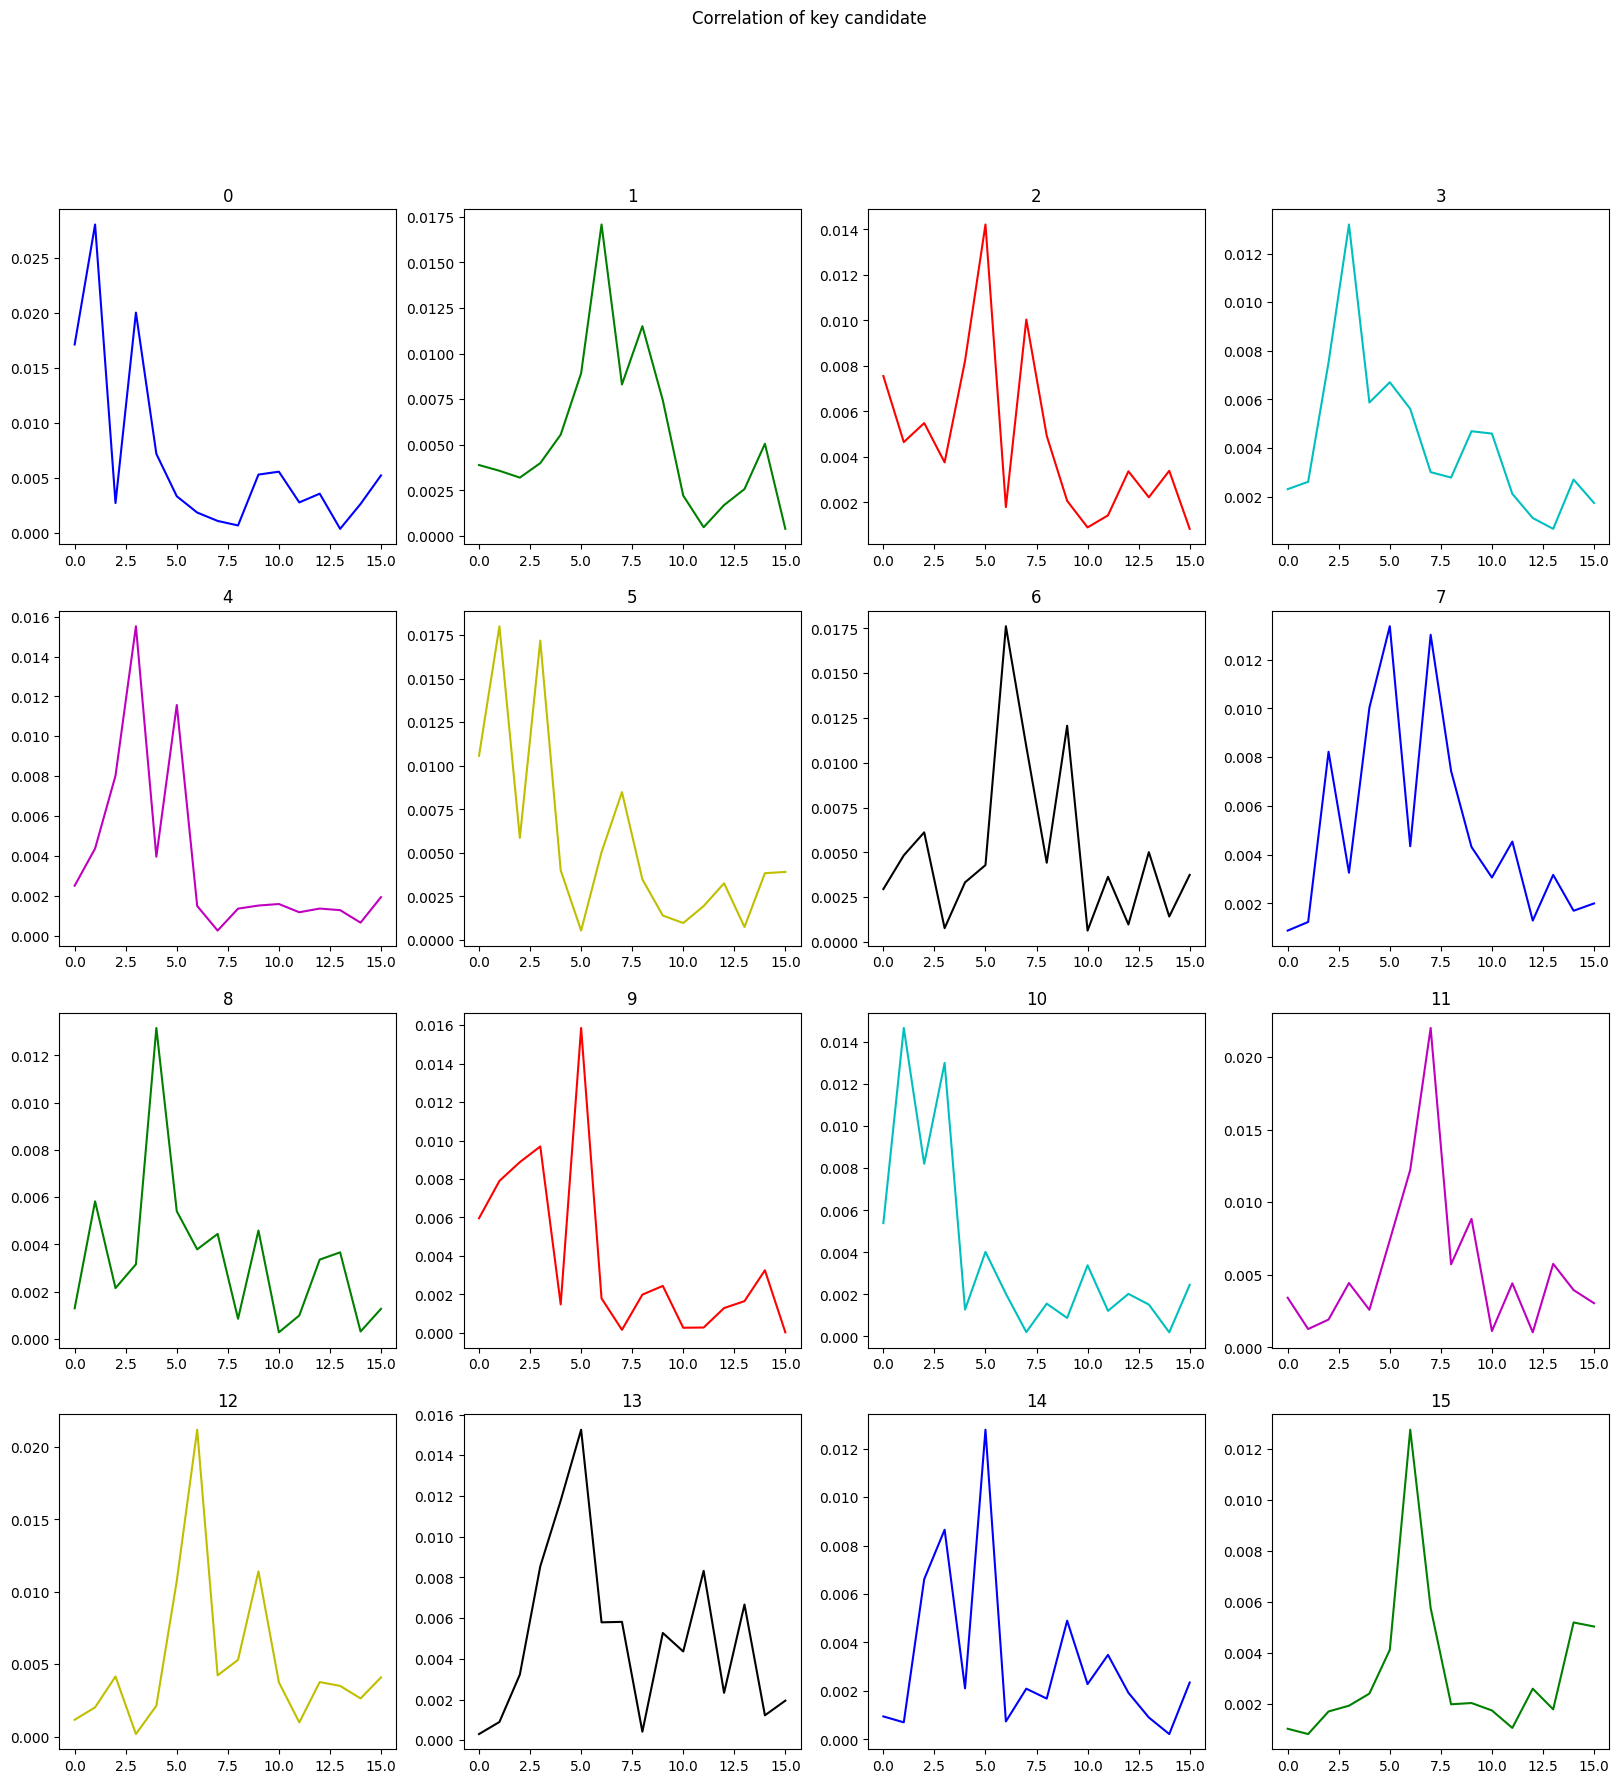

In [25]:
# Correlation visualisation
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20,20))
fig.suptitle("Correlation of key candidate")
i = 0

for x in ax:
    for y in x:
        y.set_title(i)
        if len(corrs_max[i]) > 0:
            y.plot(corrs_max[i][-1],label=i,color=colors[i%7])
        i += 1